In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import datetime
from collections import OrderedDict 
import numpy

In [ ]:
torch.cuda.empty_cache()

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
def show_sample():
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
    dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=0,
                            batch_size=8)
    dataiter = iter(dataloader)


    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1]),0)
    imshow(torchvision.utils.make_grid(concatenated))
    print(example_batch[2].numpy())

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self,no_of_layers):
        super(SiameseNetwork, self).__init__()
        layer=OrderedDict()
        
        layer[str(1)]=nn.ReflectionPad2d(1)
        layer[str(2)]=nn.Conv2d(1, 4, kernel_size=3)
        layer[str(3)]=nn.ReLU(inplace=True)
        layer[str(4)]=nn.BatchNorm2d(4)
        
        layer[str(5)]=nn.ReflectionPad2d(1)
        layer[str(6)]=nn.Conv2d(4, 8, kernel_size=3)
        layer[str(7)]=nn.ReLU(inplace=True)
        layer[str(8)]=nn.BatchNorm2d(8)
        
        z=8
        for i in range(no_of_layers):
            z=z+1
            layer[str(z)]=nn.ReflectionPad2d(1)
            z=z+1
            layer[str(z)]=nn.Conv2d(8, 8, kernel_size=3)
            z=z+1
            layer[str(z)]=nn.ReLU(inplace=True)
            z=z+1
            layer[str(z)]=nn.BatchNorm2d(8)
        
        self.cnn1 = nn.Sequential(layer)
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [9]:
class Loss_Function(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(Loss_Function, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss

In [10]:

def train_network(train_batch_size = 64,train_number_epochs = 100,learning_rate=0.05,no_of_layers=1):
    
    
    print("Loading Training Data...")
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))
    train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=0,batch_size=train_batch_size)
    print("Building Model Architecure...")
    net = SiameseNetwork(no_of_layers).cuda()

    criterion = Loss_Function()
    optimizer = optim.Adam(net.parameters(),lr = learning_rate)
    counter = []
    loss_history = [] 
    iteration_number= 0
    print('Parameters:')
    print('Batch Size:'+str(train_batch_size))
    print('No of Epochs:'+str(train_number_epochs))
    print('Learning Rate:'+str(learning_rate))
    
    
    start=datetime.datetime.now()
    print("Initializing Training at "+str(start))
    for epoch in range(0,train_number_epochs):
        if epoch% 10 ==0:
            if(epoch!=0):
                time_sec=(datetime.datetime.now()-start).total_seconds()
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_history[-1]))
                print('Time_Taken:'+str(time_sec)+" ,Time per Iteration: "+str(time_sec/epoch))
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())


    time_sec=(datetime.datetime.now()-start).total_seconds()
    print('Total Time Taken:'+str(time_sec)+" ,Average Time per Iteration: "+str(time_sec/train_number_epochs))

    show_plot(counter[10:],loss_history[10:])
    
    torch.save(net,"models/"+str(train_batch_size)+"_"+str(train_number_epochs)+"_"+str(learning_rate)+"_"+str(no_of_layers)+".pt")
    
    
    
    folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transforms.Compose([transforms.Resize((100,100)),
                                                                          transforms.ToTensor()
                                                                          ])
                                           ,should_invert=False)

    test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
    dataiter = iter(test_dataloader)
    x0,_,_ = next(dataiter)

    for i in range(10):
        _,x1,label2 = next(dataiter)
        concatenated = torch.cat((x0,x1),0)

        output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    return loss_history[-1]
#loss=train_network(train_number_epochs=20)


In [ ]:
population=numpy.array([[64,1000,0.05,1],
       [32,2000,0.005,2],
       [16,3000,0.01,3],
       [64,4000,0.0005,4],
       [32,5000,0.001,1]
      ])




def get_fitness_value(parameters):
    loss=train_network(int(parameters[0]),int(parameters[1]),parameters[2],int(parameters[3]))
    return loss

def select_suitable_parents(population,fitness,population_size):
    

def run_genetic_algorithm(population,no_of_generations=5):
    population_size=len(population)
    for each in range(no_of_generations):
        fitness=numpy.zeros(population_size)
        for i in range(population_size):
            fitness[i]=get_fitness_value(population[i])
        selected_parents=select_suitable_parents(population,fitness,population_size)
        
    
#run_genetic_algorithm(population)

Loading Training Data...
Building Model Architecure...


Parameters:
Batch Size:64
No of Epochs:1000
Learning Rate:0.05
Initializing Training at 2018-10-12 12:56:40.761092


KeyboardInterrupt: 

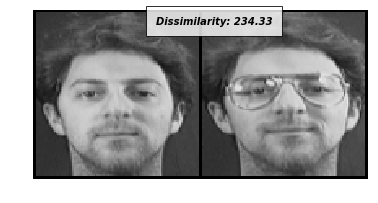

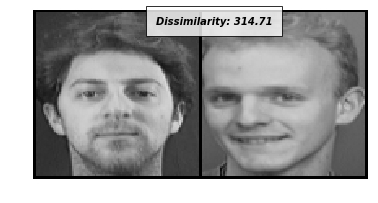

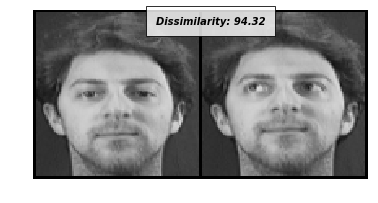

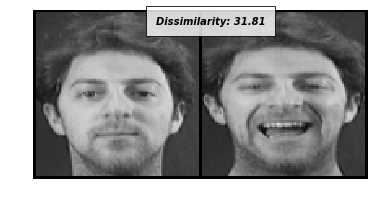

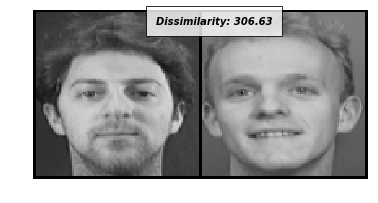

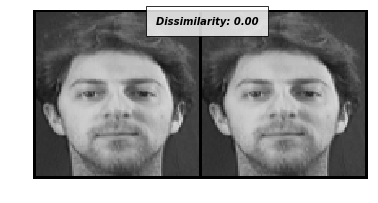

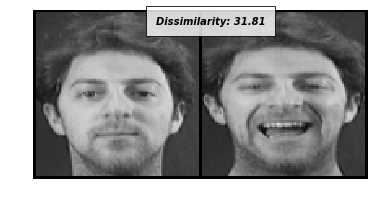

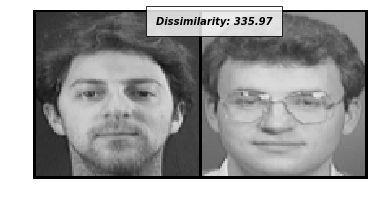

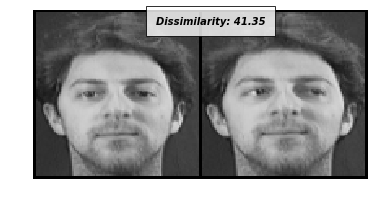

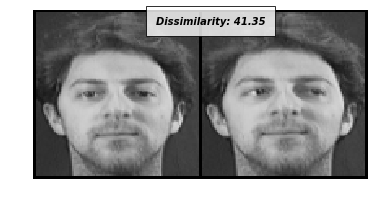

In [25]:
net = SiameseNetwork().cuda()
net = torch.load("test_model.pt")
net.eval()
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

